In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import pandas as pd
import xarray as xr

import ecephys_analyses as ea

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [4]:
xr.set_options(keep_attrs=True)

In [57]:
experiment = "sleep-homeostasis"
nrem = ["N1", "N2"]
light_period_start = "09:00:00"
light_period_end = "21:00:00"
            
def get_abs_sink(spws):
    _spws = spws.copy()
    _spws['sink_amplitude'] = spws['sink_amplitude'].abs()
    _spws['sink_integral'] = spws['sink_amplitude'].abs()
    return _spws

def load_baseline_light_period_nrem(subject, abs_sink=False):
    condition = "light-period-circadian-match"
    hyp = ea.load_hypnogram(subject, experiment, condition)
    hyp = hyp.keep_states(nrem).keep_between(light_period_start, light_period_end)
    spws = ea.load_spws(subject, experiment, condition)
    spws = spws[hyp.covers_time(spws.start_time)]
    if abs_sink:
        spws = get_abs_sink(spws)
    return hyp, spws


def load_early_recovery_nrem(subject, abs_sink=False):
    condition = "recovery-sleep"
    duration = "01:00:00"
    hyp = ea.load_hypnogram(subject, experiment, condition)
    hyp = hyp.keep_states(nrem).keep_first(duration)
    spws = ea.load_spws(subject, experiment, condition)
    spws = spws[hyp.covers_time(spws.start_time)]
    if abs_sink:
        spws = get_abs_sink(spws)
    return hyp, spws

def load_late_recovery_nrem(subject, abs_sink=False):
    condition = "recovery-sleep"
    duration = "01:00:00"
    hyp = ea.load_hypnogram(subject, experiment, condition)
    hyp = hyp.keep_states(nrem).keep_last(duration)
    spws = ea.load_spws(subject, experiment, condition)
    spws = spws[hyp.covers_time(spws.start_time)]
    if abs_sink:
        spws = get_abs_sink(spws)
    return hyp, spws


def load_first2h_recovery_nrem(subject, abs_sink=False):
    condition = "recovery-sleep"
    duration = "02:00:00"
    hyp = ea.load_hypnogram(subject, experiment, condition)
    hyp = hyp.keep_states(nrem).keep_first(duration)
    spws = ea.load_spws(subject, experiment, condition)
    spws = spws[hyp.covers_time(spws.start_time)]
    if abs_sink:
        spws = get_abs_sink(spws)
    return hyp, spws


def load_first2h_recovery_match_nrem(subject, rec_hyp, abs_sink=False):
    condition = "recovery-sleep-circadian-match"
    duration = "02:00:00"
    hyp = ea.load_hypnogram(subject, experiment, condition)
    hyp = (
        hyp.keep_states(nrem)
        .keep_between(rec_hyp.start_time.min().strftime("%H:%M:%S"), light_period_end)
        .keep_first(duration)
    )
    spws = ea.load_spws(subject, experiment, condition)
    spws = spws[hyp.covers_time(spws.start_time)]
    if abs_sink:
        spws = get_abs_sink(spws)
    return hyp, spws

In [58]:
def get_isi(spws):
    return (spws.start_time[1:].values - spws.end_time[:-1].values) / pd.to_timedelta(1, 's')

In [73]:
subjects = ['Segundo', 'Valentino', 'Doppio', 'Alessandro', 'Allan']

subj_dfs = list()

for subject in subjects:
    #bsl_spws = ea.load_spws(subject, 'sleep-homeostasis', 'light-period-circadian-match')
    #rec_spws = ea.load_spws(subject, 'sleep-homeostasis', 'recovery-sleep')
    rec_hyp, rec_spws = load_first2h_recovery_nrem(subject)
    bsl_hyp, bsl_spws = load_first2h_recovery_match_nrem(subject, rec_hyp)
    #dep_spws = ea.load_spws(subject, 'sleep-homeostasis', 'extended-wake')
    
    bsl_isi = get_isi(bsl_spws)
    #dep_isi = get_isi(dep_spws)
    rec_isi = get_isi(rec_spws)
    
    bsl_isi_df = pd.DataFrame({'isi': bsl_isi, 'condition': 'baseline'})
    #dep_isi_df = pd.DataFrame({'isi': dep_isi, 'condition': 'deprivation'})
    rec_isi_df = pd.DataFrame({'isi': rec_isi, 'condition': 'recovery'})

    #subj_dfs.append(pd.concat([bsl_isi_df, dep_isi_df, rec_isi_df]).assign(subject=subject))
    subj_dfs.append(pd.concat([bsl_isi_df, rec_isi_df]).assign(subject=subject))

all_subjects_df = pd.concat(subj_dfs, ignore_index=True)

In [81]:
def plot_subject(subject, all_subjects_df, col='isi', log_scale=True):
    df = all_subjects_df[all_subjects_df['subject'] == subject]
    thresh = df[col].mean() + df[col].std() * 3
    df = df[df[col] < thresh]
    fig, axes = plt.subplots(1, 4, figsize=(32, 6))
    fig.suptitle(subject)
    sns.histplot(df, x=col, hue='condition', log_scale=log_scale, ax=axes[0])
    axes[0].set(title='Unnormalized')
    sns.histplot(df, x=col, hue='condition', stat='probability', common_norm=False, log_scale=log_scale, ax=axes[1])
    axes[1].set(title='Normalized probability')
    sns.histplot(df, x=col, hue='condition', stat='density', common_norm=False, log_scale=log_scale, ax=axes[2])
    axes[2].set(title='Normalized density')
    
    df[col] = np.log10(df[col])
    sns.ecdfplot(df, x=col, hue='condition', ax=axes[3])
    axes[3].set(title='Empirical CDF')

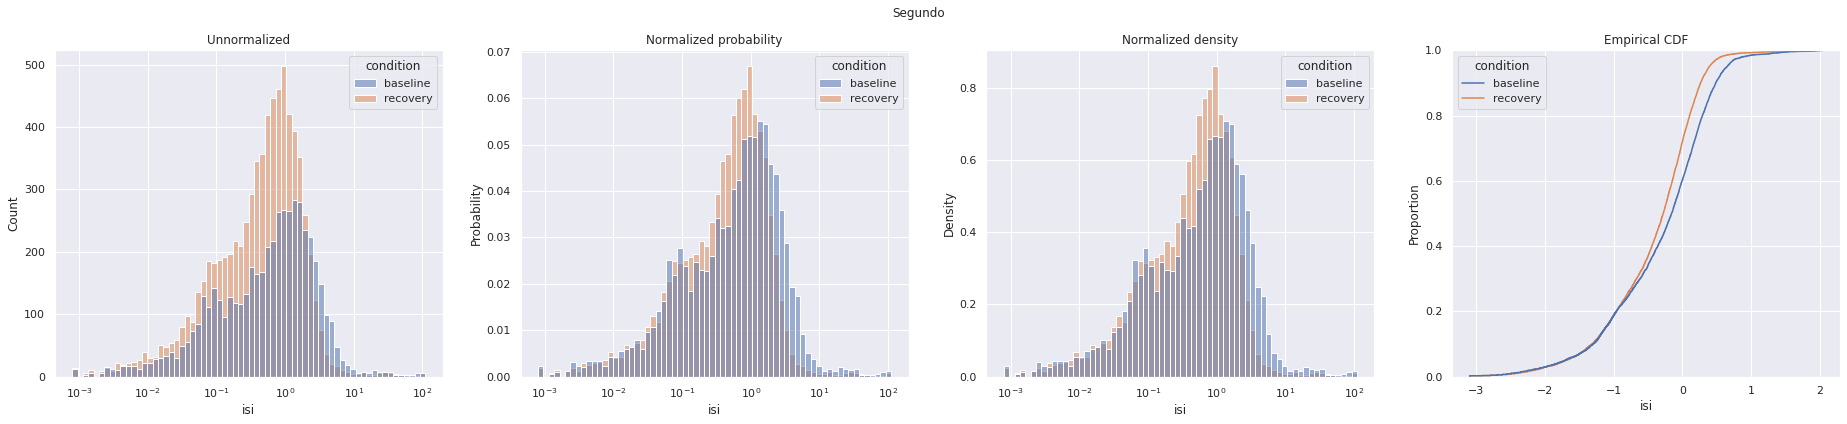

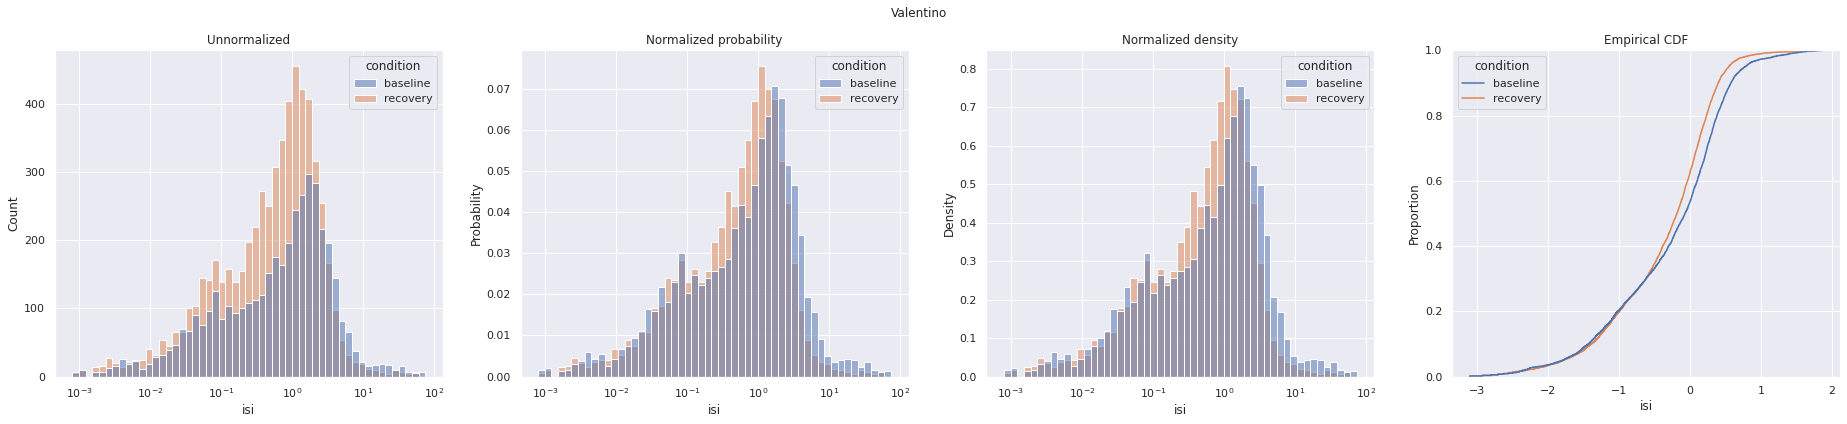

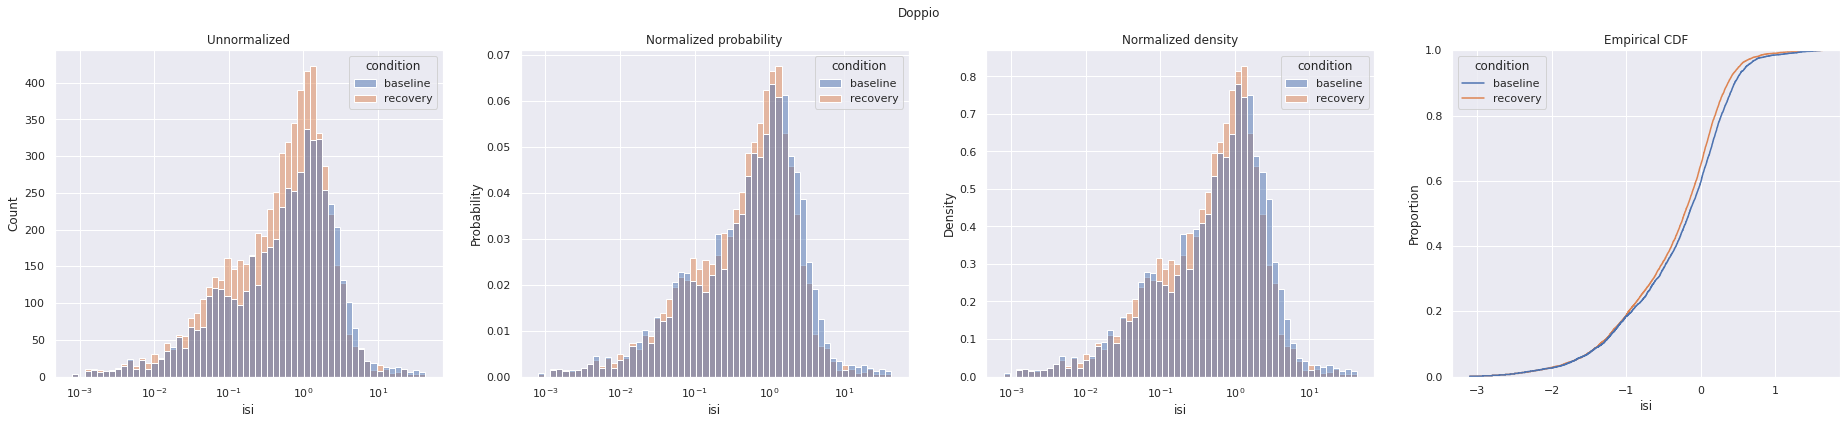

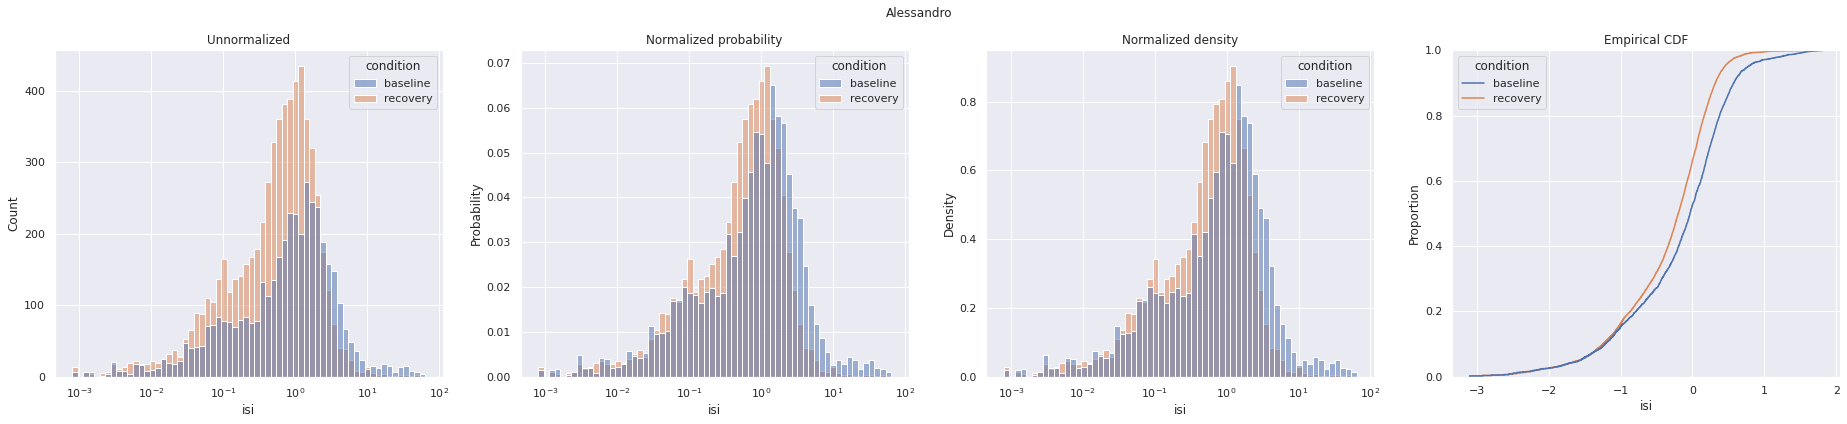

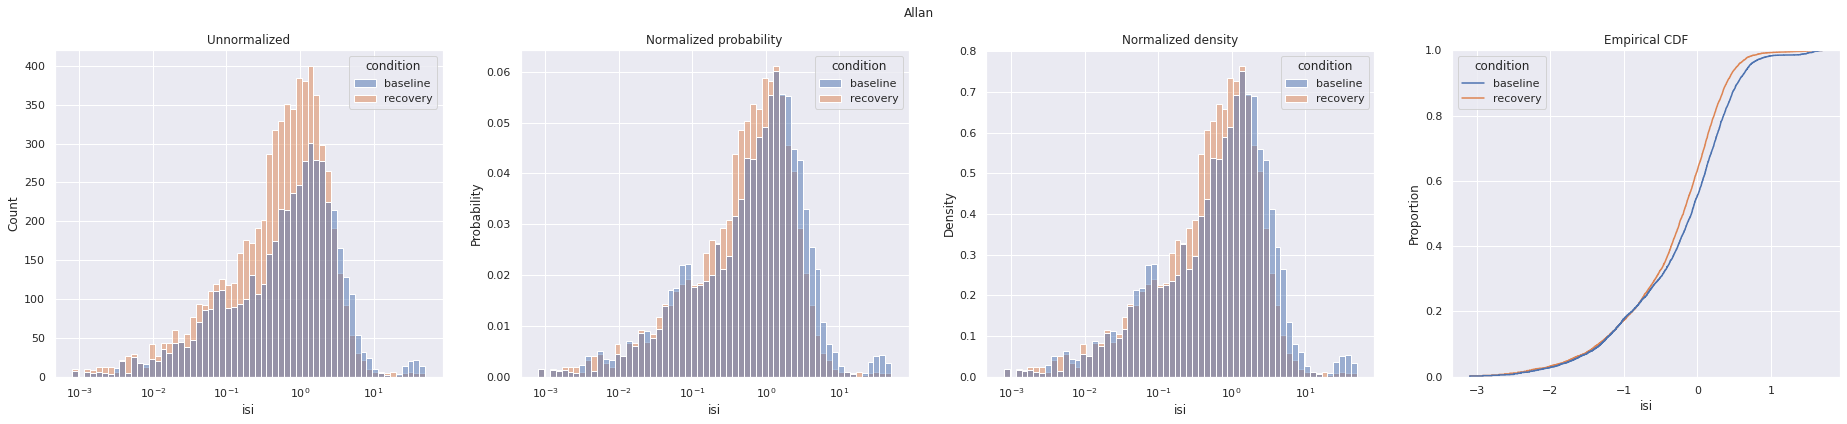

In [82]:
for subject in subjects:
    plot_subject(subject, all_subjects_df)